This notebook is part of the *orix* documentation https://orix.rtfd.io. Links to the documentation won’t work from the notebook.

# Clustering across fundamental region boundaries

This tutorial demonstrates density based clustering of crystal orientations with
and without the application of crystal symmetry using simulated data, as
presented in
<cite data-cite="johnstone2020density">Johnstone et al. (2020)</cite>.

Import orix classes and various dependencies

In [1]:
# exchange inline for notebook (or qt5 from pyqt) for interactive plotting
%matplotlib inline

# Import core external
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Colorisation & Animation
from skimage.color import label2rgb
from matplotlib.colors import to_rgb
import matplotlib.animation as animation

# Import orix classes
from orix.quaternion import Orientation, OrientationRegion, Rotation
from orix.quaternion.symmetry import C1, Oh
from orix.vector import AxAngle

## Generate artificial data

Generate three random von Mises distributions of orientations as model clusters
and set the *Oh* ($m\bar{3}m$) point group symmetry

In [2]:
n_orientations = 50
alpha = 50  # Lower value gives "looser" distribution

# Cluster 1
cluster1 = Rotation.random_vonmises(n_orientations, alpha=alpha)

# Cluster 2
centre2 = Rotation.from_neo_euler(AxAngle.from_axes_angles((1, 0, 0), np.pi / 4))
cluster2 = Rotation.random_vonmises(n_orientations, alpha=alpha, reference=centre2)

# Cluster 3
centre3 = Rotation.from_neo_euler(AxAngle.from_axes_angles((1, 1, 0), np.pi / 3))
cluster3 = Rotation.random_vonmises(n_orientations, alpha=alpha, reference=centre3)

# Stack and map into the Oh fundamental zone
ori = Orientation.stack([cluster1, cluster2, cluster3]).flatten()
ori.symmetry = Oh
ori = ori.map_into_symmetry_reduced_zone()

## Orientation clustering

### Perform clustering without application of crystal symmetry

Compute misorientations, i.e. distance between orientations

In [3]:
# Remove symmetry by setting it to point group 1 (identity operation)
ori_without_symmetry = Orientation(ori.data, symmetry=C1)

# Misorientations
mori1 = (~ori_without_symmetry).outer(ori_without_symmetry)

# Misorientation angles
D1 = mori1.angle

Perform clustering

In [4]:
dbscan_naive = DBSCAN(eps=0.3, min_samples=10, metric="precomputed").fit(D1)
print("Labels:", np.unique(dbscan_naive.labels_))

Labels: [0 1 2 3]


### Perform clustering with application of crystal symmetry

Compute misorientations, i.e. distance between orientations, with symmetry

In [5]:
mori2 = (~ori).outer(ori)

mori2.symmetry = Oh
mori2 = mori2.map_into_symmetry_reduced_zone()

D2 = mori2.angle

# Or get the angles using Dask
#D2 = ori.get_distance_matrix().data

Perform clustering

In [6]:
dbscan = DBSCAN(eps=0.3, min_samples=20, metric="precomputed").fit(D2)
print("Labels:", np.unique(dbscan.labels_))

Labels: [0 1]


This should have shown that without symmetry there are 6 clusters, whereas with symmetry there are 3.

## Visualisation

Assign colours to each cluster

In [7]:
color_names = [to_rgb(f"C{i}") for i in range(6)]  # ['C0', 'C1', ...]

colors_naive = label2rgb(dbscan_naive.labels_, colors=color_names, bg_label=-1)
colors = label2rgb(dbscan.labels_, colors=color_names, bg_label=-1)

Plot orientation clusters with Matplotlib and
[(Mis)orientation.scatter()](reference.rst#orix.quaternion.Misorientation.scatter)

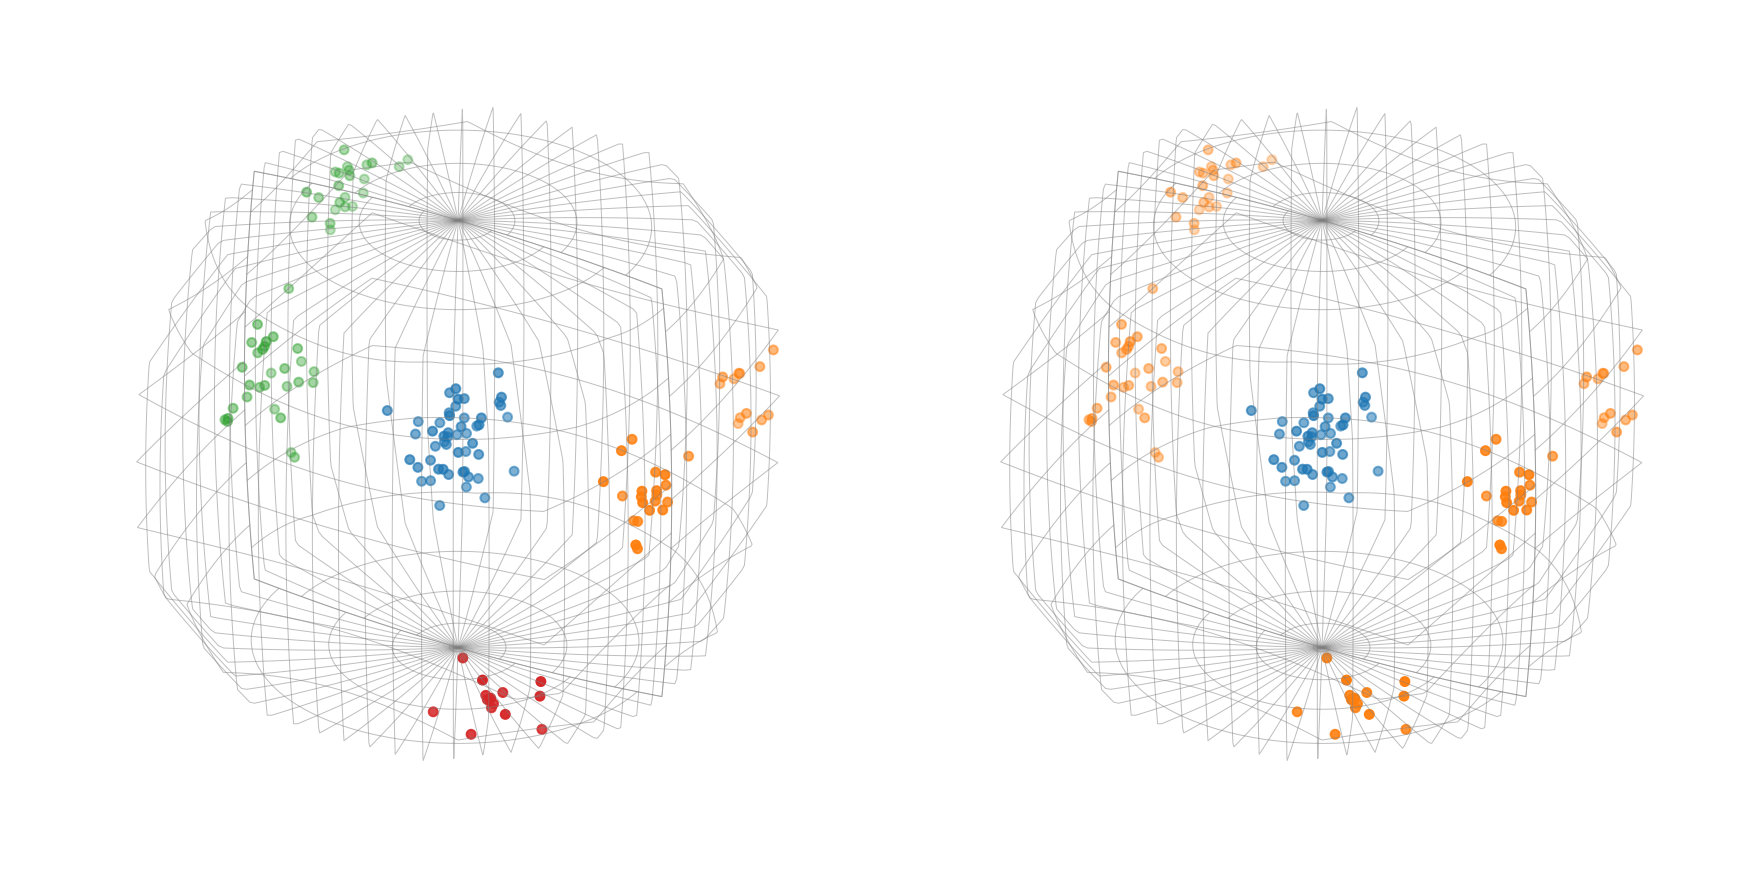

In [8]:
# Set symmetry to "trick" the scatter plot to use the Oh fundamental zone
ori_without_symmetry.symmetry = ori.symmetry

# Create figure with a height/width ratio of 1/2
fig = plt.figure(figsize=(12, 6))

# Add the fundamental zones with clusters to the existing figure
ori_without_symmetry.scatter(figure=fig, position=(1, 2, 1), c=colors_naive)
ori.scatter(figure=fig, position=122, c=colors)

Generate an animation of the plot (assuming an interactive Matplotlib backend is used)

In [9]:
def animate(angle):
    ax0, ax1 = fig.axes
    ax0.view_init(15, angle)
    ax1.view_init(15, angle)
    plt.draw()

ani = animation.FuncAnimation(fig, animate, np.linspace(75, 360+74, 720), interval=25)